In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "PlantVillage"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 12442 files belonging to 11 classes.


In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

11 ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


2023-03-16 23:38:05.773973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-16 23:38:16.335980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 291 of 10000
2023-03-16 23:38:19.158627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


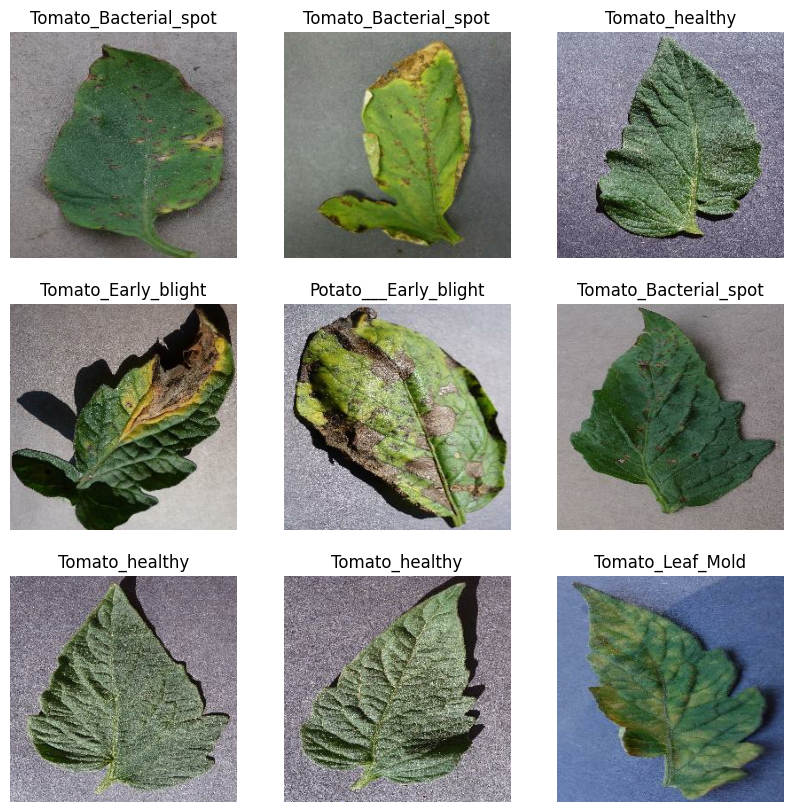

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [17]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50


2023-03-16 23:38:56.353635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - ETA: 0s - loss: 1.6720 - accuracy: 0.4146

2023-03-16 23:40:33.943542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-16 23:40:44.144910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 367 of 10000
2023-03-16 23:40:45.019561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-03-16 23:40:45.382602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-03-16 23:40:45.440001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


311/311 [==============================] - 116s 334ms/step - loss: 1.6720 - accuracy: 0.4146 - val_loss: 1.1312 - val_accuracy: 0.5929
Epoch 2/50
311/311 [==============================] - 92s 292ms/step - loss: 0.7897 - accuracy: 0.7264 - val_loss: 0.6039 - val_accuracy: 0.7648
Epoch 3/50
311/311 [==============================] - 89s 285ms/step - loss: 0.5170 - accuracy: 0.8215 - val_loss: 0.4796 - val_accuracy: 0.8199
Epoch 4/50
311/311 [==============================] - 91s 293ms/step - loss: 0.3884 - accuracy: 0.8640 - val_loss: 0.3489 - val_accuracy: 0.8799
Epoch 5/50
311/311 [==============================] - 92s 295ms/step - loss: 0.3084 - accuracy: 0.8890 - val_loss: 0.2850 - val_accuracy: 0.8997
Epoch 6/50
311/311 [==============================] - 89s 285ms/step - loss: 0.2519 - accuracy: 0.9128 - val_loss: 0.2298 - val_accuracy: 0.9227
Epoch 7/50
311/311 [==============================] - 86s 277ms/step - loss: 0.2166 - accuracy: 0.9227 - val_loss: 0.1484 - val_accuracy: 0.

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
40/40 [==============================] - 16s 108ms/step - loss: 0.0194 - accuracy: 0.9977
Test Accuracy: 99.77000000000001%


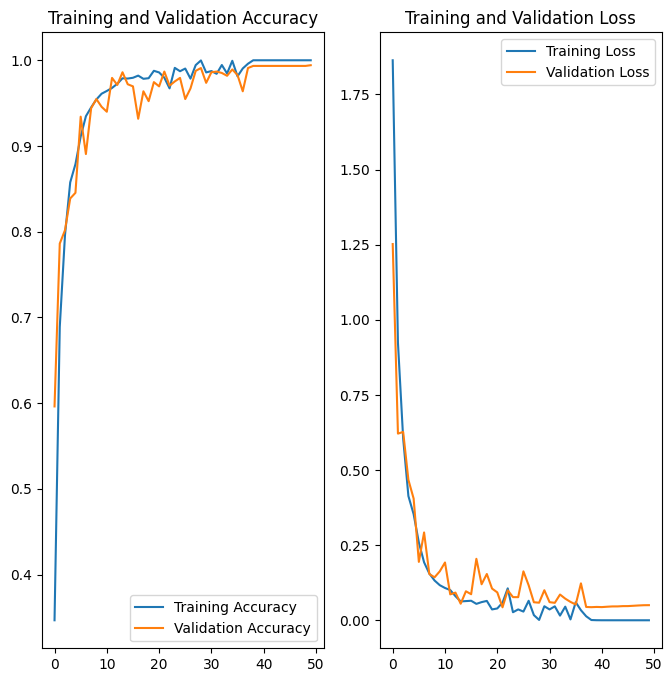

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

2023-03-14 14:26:36.728465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


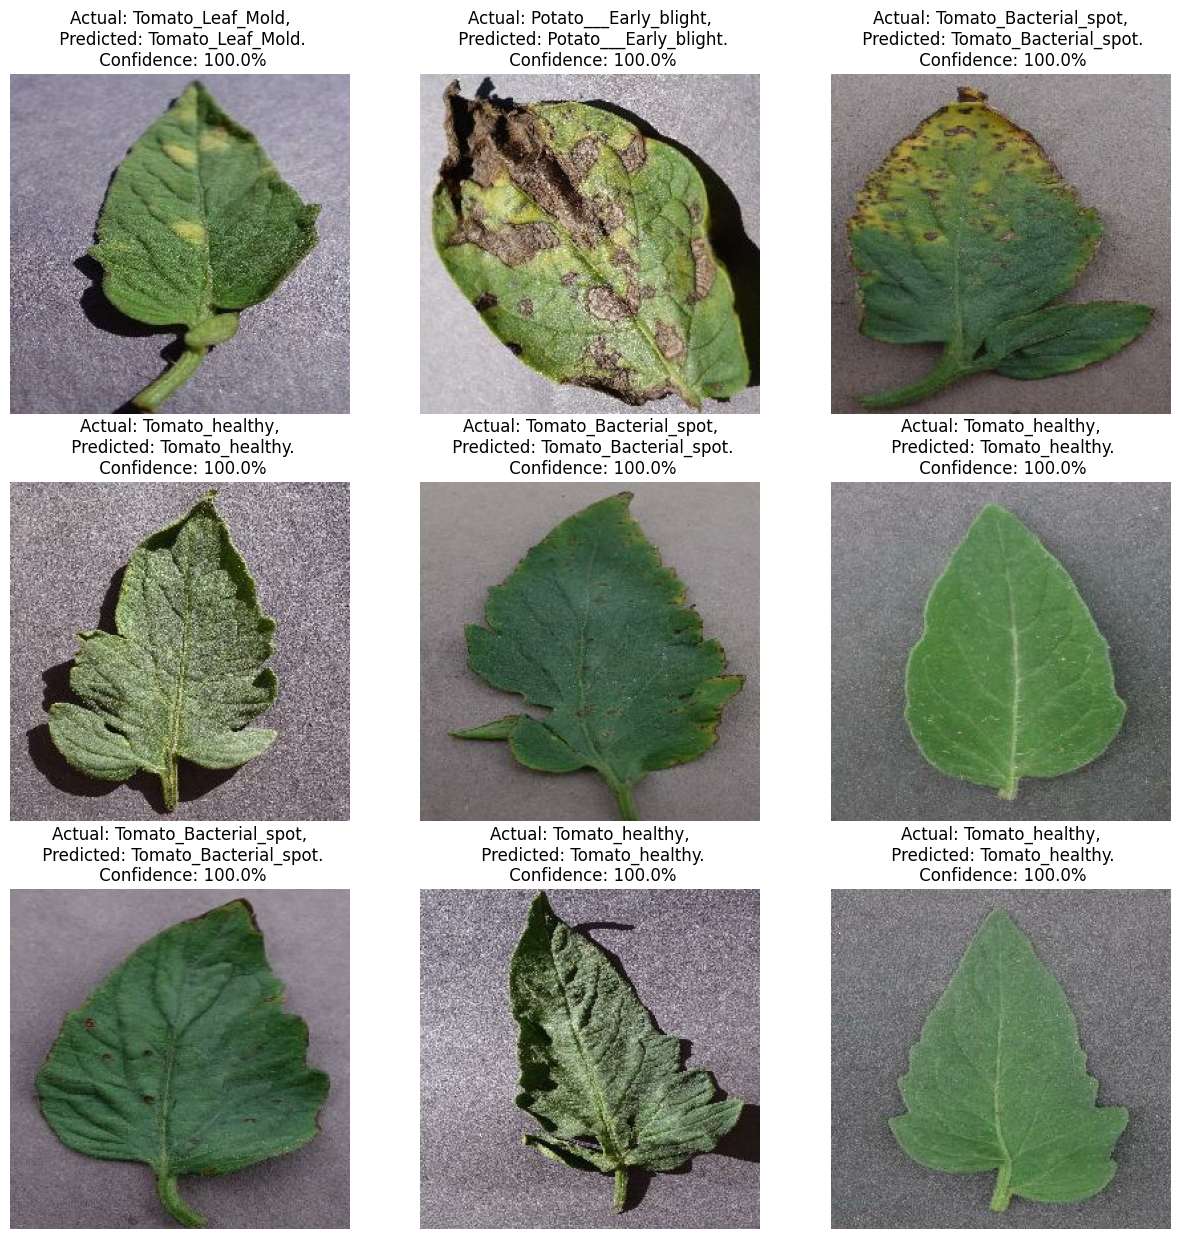

In [20]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")


In [51]:
model_version='firstmodel'
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/firstmodel/assets


INFO:tensorflow:Assets written to: ../models/firstmodel/assets
